In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import cv2
import os
import argparse
import json
from collections import namedtuple
from tqdm import tqdm
import torchgeometry as tgm
from collections import defaultdict
import config
import constants
from models import hmr, SMPL
from datasets import BaseDataset
from utils.imutils import uncrop
from utils.pose_utils import reconstruction_error, compute_similarity_transform_batch
from utils.part_utils import PartRenderer
from utils.geometry import rot6d_to_rotmat, batch_rodrigues, perspective_projection
import pandas as pd

Setting np random seed: 0


In [2]:
def compute_pck(error_2d_batch, alpha):
    pck = np.zeros((len(error_2d_batch)))
    pck_ka = np.zeros((len(error_2d_batch)))
    for i_ in range(curr_batch_size):
        error_2d =  np.sqrt(error_2d_batch[i_, gt_keypoints_2d[i_, :, 2]==1].numpy().sum(axis=-1))
        mpjpe[i_] = error_2d.mean(axis=-1) # averaging over all joints.

        num_annotated_kp = (gt_keypoints_2d[i_, :, 2]==1).sum()
        pck[i_] = (error_2d < alpha).sum() * 1. / num_annotated_kp.item()
    return pck

## Report PCK per joint

In [11]:
exps = {
    'rand. pose': '../synthetic_hmr/result_files/seedlings_rand_vposer.npz',
    'SURREAL': '../synthetic_hmr/result_files/seedlings_surreal_texture.npz',
    'Ours': '../synthetic_hmr/result_files/ours.npz',
    'Ours (overall)': '../synthetic_hmr/result_files/seedlings_aug_overall.npz'
}
# exps = {
#     'Ours (overall)': '../synthetic_hmr/result_files/seedlings_aug_overall.npz',
#     'Ours (visible)': '../synthetic_hmr/result_files/seedlings_aug_visible.npz',
#     'Ours (inferred)': '../synthetic_hmr/result_files/seedlings_aug_inferred.npz'
# }
joint_map = {
    'eye': [21,20], 'shoulder': [8,9], 'elbow': [7,10], 'wrist': [6,11], 'hip': [2,3], 'knee': [1,4], 'ankle': [0,5]
}

In [12]:
pck_by_exp = {exp: dict() for exp in exps}
pckpj_by_exp = {j: {exp: dict() for exp in exps} for j in joint_map.keys()}
thres = 224/3/5
for exp in exps:
    pck_all_joints = []
    result = np.load(exps[exp])
    errors = result['error_per_joint']
    for i in range(450):
        num_annotated_kp = len(errors[:,i][~np.isnan(errors[:,i])])
        pck_all_joints.append((errors[:,i] < thres).sum() * 1. / num_annotated_kp)

    for joint_name, joint_idxs in joint_map.items():
        res_joint = errors[joint_idxs]
        res_joint = res_joint[~np.isnan(res_joint)]
        pckpj_by_exp[joint_name][exp] = round((res_joint<thres).sum() / len(res_joint) * 100, 1)

    pck_by_exp[exp] = np.array(pck_all_joints).mean() * 100
# pck_by_exp
# pckpj_by_exp

In [13]:
pd.DataFrame(pckpj_by_exp)

,eye,shoulder,elbow,wrist,hip,knee,ankle
rand. pose,81.0,56.1,73.0,64.0,53.6,41.7,26.2
SURREAL,83.3,74.8,65.7,65.7,62.8,44.5,28.0
Ours,85.9,79.4,74.2,67.5,63.5,48.8,31.4
Ours (overall),81.7,75.5,67.6,56.8,55.0,47.0,29.1


In [41]:
pd.DataFrame(pckpj_by_exp)

,eye,shoulder,elbow,wrist,hip,knee,ankle
rand. pose,81.0,56.1,73.0,64.0,53.6,41.7,26.2
SURREAL,83.3,74.8,65.7,65.7,62.8,44.5,28.0
Ours,85.9,79.4,74.2,67.5,63.5,48.8,31.4


## PCK Curves

In [8]:
exps = {
    'Ours': '../synthetic_hmr/result_files/ours.npz',
    'SPIN-ft': '../synthetic_hmr/result_files/spin.npz',
    'SPIN-pt': '../synthetic_hmr/result_files/pretrained.npz'
}
joint_map = {
    'ankle': [0,5], 'knee': [1,4], 'Other joints': [21,20, 8,9, 7,10, 6,11,2,3]
}
thresholds = np.linspace(3, 50, 10)
pck_by_exp = {exp: dict() for exp in exps}
pckpj_by_exp = {j: {exp: dict() for exp in exps} for j in joint_map.keys()}

for thres in thresholds:
    for exp in exps:
        pck_all_joints = []
        result = np.load(exps[exp])
        errors = result['error_per_joint']
        for i in range(450):
            num_annotated_kp = len(errors[:,i][~np.isnan(errors[:,i])])
            pck_all_joints.append((errors[:,i] < thres).sum() * 1. / num_annotated_kp)
            
        for joint_name, joint_idxs in joint_map.items():
            res_joint = errors[joint_idxs]
            res_joint = res_joint[~np.isnan(res_joint)]
            pckpj_by_exp[joint_name][exp][thres] = (res_joint<thres).sum() / len(res_joint) * 100
            
        pck_by_exp[exp][thres] = np.array(pck_all_joints).mean() * 100

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
sns.set()
sns.set_style("whitegrid")

NameError: name 'sns' is not defined

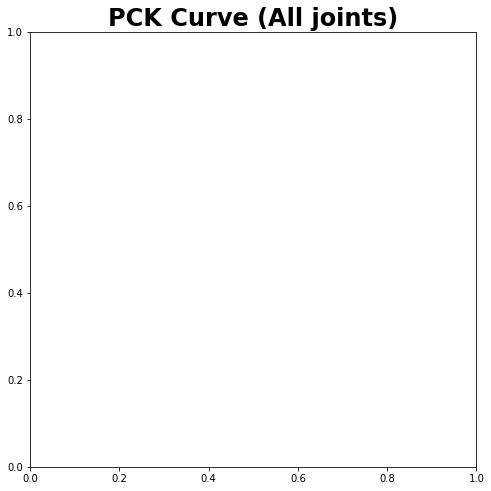

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

df = pd.DataFrame(pck_by_exp)
# plt.subplot()
plt.title('PCK Curve (All joints)', fontsize=24, fontweight='bold')
sns.lineplot(data=df, markers=True, dashes=False, linewidth=2, markersize=10)
plt.xlabel('threshold (pixel)', fontsize=20)
plt.ylabel('PCK (%)', fontsize=20)
plt.setp(axs.get_legend().get_texts(), fontsize='24') # for legend text


# plt.savefig('pck_curve_all.png', bbox_inches='tight', dpi=200)

[None, None, None, None, None, None]

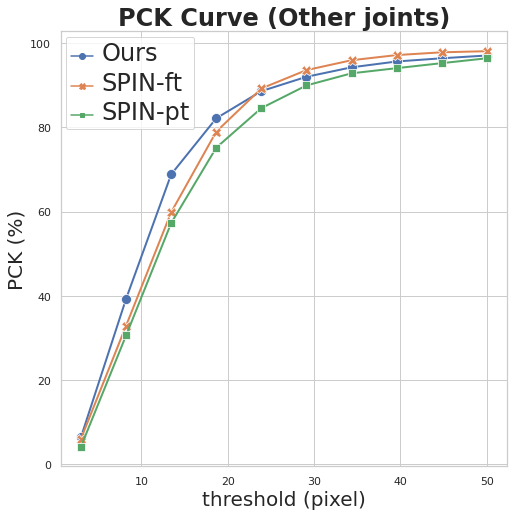

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

df = pd.DataFrame(pckpj_by_exp['Other joints'])
# plt.subplot()
plt.title('PCK Curve (Other joints)', fontsize=24, fontweight='bold')
sns.lineplot(data=df, markers=True, dashes=False, linewidth=2, markersize=10)
plt.xlabel('threshold (pixel)', fontsize=20)
plt.ylabel('PCK (%)', fontsize=20)
plt.setp(axs.get_legend().get_texts(), fontsize='24') # for legend text


[None, None, None, None, None, None]

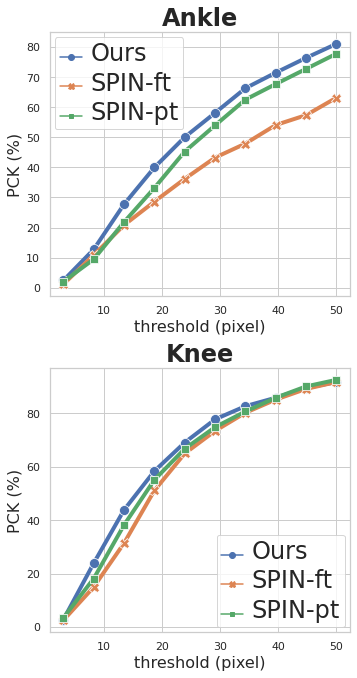

In [9]:
fig, axs = plt.subplots(2,1, figsize=(6, 10))
plt.tight_layout(pad=4)
df2 = pd.DataFrame(pckpj_by_exp['ankle'])
plt.subplot(axs[0])
plt.title('Ankle', fontsize=24, fontweight='bold')
sns.lineplot(data=df2, markers=True, dashes=False, linewidth=4, markersize=10)
plt.xlabel('threshold (pixel)', fontsize=16)
plt.ylabel('PCK (%)', fontsize=16)
plt.setp(axs[0].get_legend().get_texts(), fontsize='24') # for legend text

df2 = pd.DataFrame(pckpj_by_exp['knee'])
plt.subplot(axs[1])
plt.title('Knee', fontsize=24, fontweight='bold')
sns.lineplot(data=df2, markers=True, dashes=False, linewidth=4, markersize=10)
plt.xlabel('threshold (pixel)', fontsize=16)
plt.ylabel('PCK (%)', fontsize=16)
plt.setp(axs[1].get_legend().get_texts(), fontsize='24') # for legend text

# df2 = pd.DataFrame(pckpj_by_exp['hip'])
# plt.subplot(axs[1,1])
# plt.title('PCK Curve (Hip)', fontsize=22, fontweight='bold')
# sns.lineplot(data=df2, markers=True, dashes=False)
# plt.xlabel('Threshold (pixel)', fontsize=18)
# plt.ylabel('PCK (%)', fontsize=18)

# plt.savefig('pck_curve_ankleknee_vertical.png', bbox_inches='tight', dpi=200)